In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Logistic

In [4]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    #classes = ['untreated', 'single_dose', 'drug_screened']
    classes = ['sort_ds_ohne_cond10_ex', 'sort_ex_85']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\softmax_dataset\2_class\final_eval"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    #classes = ['untreated', 'single_dose', 'drug_screened']
    classes = ['ex', 'sd', 'cond7_all']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [5]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1])


In [6]:
def prepare_data_features(dataloader):
    feats, labels = [], []
    
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        
        # Flatten the images from (N, C, H, W) to (N, C*H*W)
        batch_feats = batch_imgs.view(batch_imgs.size(0), -1)  # Flatten the images
        print(f"Batch features shape: {batch_feats.shape}")  # Check the feature shape
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)


In [7]:
# Extract features for train and test datasets
train_feats = prepare_data_features(train_loader_labeled)
test_feats = prepare_data_features(test_loader_labeled)

  7%|▋         | 1/15 [00:00<00:09,  1.50it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 13%|█▎        | 2/15 [00:01<00:08,  1.51it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 20%|██        | 3/15 [00:01<00:07,  1.54it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 27%|██▋       | 4/15 [00:02<00:07,  1.55it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 33%|███▎      | 5/15 [00:03<00:06,  1.53it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 40%|████      | 6/15 [00:03<00:05,  1.54it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 47%|████▋     | 7/15 [00:04<00:05,  1.54it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 53%|█████▎    | 8/15 [00:05<00:04,  1.55it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 60%|██████    | 9/15 [00:05<00:03,  1.54it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 67%|██████▋   | 10/15 [00:06<00:03,  1.56it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 73%|███████▎  | 11/15 [00:07<00:02,  1.55it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 80%|████████  | 12/15 [00:07<00:01,  1.54it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 87%|████████▋ | 13/15 [00:08<00:01,  1.52it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 93%|█████████▎| 14/15 [00:09<00:00,  1.51it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


Batch features shape: torch.Size([15, 27648])
Batch labels shape: torch.Size([15])
Features shape after concatenation: torch.Size([239, 27648])
Labels shape after concatenation: torch.Size([239])


 25%|██▌       | 1/4 [00:00<00:01,  1.55it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 50%|█████     | 2/4 [00:01<00:01,  1.53it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 3/4 [00:01<00:00,  1.53it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


100%|██████████| 4/4 [00:02<00:00,  1.64it/s]

Batch features shape: torch.Size([12, 27648])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([60, 27648])
Labels shape after concatenation: torch.Size([60])


In [8]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [9]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [10]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [11]:
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                             drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Track best metrics
    best_train_acc = -1.0
    best_train_epoch = -1

    best_test_acc = -1.0
    best_test_epoch = -1

    best_test_loss = float('inf')
    best_test_loss_acc = -1.0
    best_model_state_loss = None

    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)

        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Track best train accuracy
        if train_acc > best_train_acc:
            best_train_acc = train_acc
            best_train_epoch = epoch + 1

        # Track best test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_test_epoch = epoch + 1

        # Check for best loss model
        # Condition: strictly lower loss OR equal loss but higher accuracy
        if (test_loss < best_test_loss) or (test_loss == best_test_loss and test_acc > best_test_loss_acc):
            best_test_loss = test_loss
            best_test_loss_acc = test_acc
            best_model_state_loss = model.state_dict()

    # Plot results
    plt.figure(figsize=(15, 5))

    # Loss curve
    plt.subplot(1, 2, 1)
    plt.plot(range(max_epochs), train_losses, label='Train Loss')
    plt.plot(range(max_epochs), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()

    # Accuracy curve
    plt.subplot(1, 2, 2)
    plt.plot(range(max_epochs), train_accuracies, label='Train Accuracy')
    plt.plot(range(max_epochs), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curve')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Return metrics and models
    return {
        "best_train_acc": best_train_acc,
        "best_train_epoch": best_train_epoch,
        "best_test_acc": best_test_acc,
        "best_test_epoch": best_test_epoch
    }


Epoch 1/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 89.83it/s]


Training loss: 1.8537, Training accuracy: 0.6276
Test loss: 1.9541, Test accuracy: 0.7167
Epoch 2/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 76.80it/s]


Training loss: 1.3281, Training accuracy: 0.5397
Test loss: 1.0882, Test accuracy: 0.7167
Epoch 3/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 108.79it/s]


Training loss: 0.8243, Training accuracy: 0.6695
Test loss: 0.9329, Test accuracy: 0.7333
Epoch 4/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 500.01it/s]


Training loss: 0.5959, Training accuracy: 0.7364
Test loss: 1.1239, Test accuracy: 0.7333
Epoch 5/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.8097, Training accuracy: 0.6946
Test loss: 0.7288, Test accuracy: 0.7500
Epoch 6/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 400.18it/s]


Training loss: 0.6821, Training accuracy: 0.7071
Test loss: 0.7130, Test accuracy: 0.7500
Epoch 7/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5963, Training accuracy: 0.7406
Test loss: 0.6990, Test accuracy: 0.7667
Epoch 8/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5080, Training accuracy: 0.7699
Test loss: 0.5514, Test accuracy: 0.7500
Epoch 9/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 661.46it/s]


Training loss: 0.5134, Training accuracy: 0.7657
Test loss: 0.5537, Test accuracy: 0.7167
Epoch 10/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4652, Training accuracy: 0.7824
Test loss: 0.6521, Test accuracy: 0.6333
Epoch 11/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5308, Training accuracy: 0.7573
Test loss: 0.6091, Test accuracy: 0.7500
Epoch 12/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 124.55it/s]


Training loss: 0.5086, Training accuracy: 0.7699
Test loss: 0.5984, Test accuracy: 0.7500
Epoch 13/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4786, Training accuracy: 0.7950
Test loss: 0.7144, Test accuracy: 0.6167
Epoch 14/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5489, Training accuracy: 0.7531
Test loss: 0.6883, Test accuracy: 0.6000
Epoch 15/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 134.96it/s]


Training loss: 0.4832, Training accuracy: 0.7699
Test loss: 0.5964, Test accuracy: 0.7500
Epoch 16/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5542, Training accuracy: 0.7113
Test loss: 0.9080, Test accuracy: 0.7333
Epoch 17/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5439, Training accuracy: 0.7364
Test loss: 0.5667, Test accuracy: 0.7333
Epoch 18/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.07it/s]


Training loss: 0.4230, Training accuracy: 0.7866
Test loss: 0.5537, Test accuracy: 0.7667
Epoch 19/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4374, Training accuracy: 0.8075
Test loss: 0.5598, Test accuracy: 0.7833
Epoch 20/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4256, Training accuracy: 0.7824
Test loss: 0.6316, Test accuracy: 0.7500
Epoch 21/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.51it/s]


Training loss: 0.5832, Training accuracy: 0.7406
Test loss: 0.7861, Test accuracy: 0.5833
Epoch 22/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 937.07it/s]


Training loss: 0.5657, Training accuracy: 0.7573
Test loss: 0.6770, Test accuracy: 0.6167
Epoch 23/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4969, Training accuracy: 0.7782
Test loss: 0.7889, Test accuracy: 0.7500
Epoch 24/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5296, Training accuracy: 0.7531
Test loss: 0.5873, Test accuracy: 0.7833
Epoch 25/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1421.32it/s]


Training loss: 0.4528, Training accuracy: 0.8033
Test loss: 0.7344, Test accuracy: 0.6333
Epoch 26/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5834, Training accuracy: 0.7490
Test loss: 0.8075, Test accuracy: 0.6000
Epoch 27/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5240, Training accuracy: 0.7573
Test loss: 0.8409, Test accuracy: 0.7500
Epoch 28/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 500.24it/s]


Training loss: 0.4838, Training accuracy: 0.7782
Test loss: 0.5957, Test accuracy: 0.7833
Epoch 29/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4982, Training accuracy: 0.7908
Test loss: 0.7422, Test accuracy: 0.6167
Epoch 30/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5757, Training accuracy: 0.7448
Test loss: 1.0214, Test accuracy: 0.7333
Epoch 31/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 511.13it/s]


Training loss: 0.7228, Training accuracy: 0.7490
Test loss: 0.9283, Test accuracy: 0.7500
Epoch 32/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.6812, Training accuracy: 0.7280
Test loss: 1.0413, Test accuracy: 0.7500
Epoch 33/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1805.17it/s]


Training loss: 0.5541, Training accuracy: 0.7741
Test loss: 0.9070, Test accuracy: 0.7667
Epoch 34/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.5092, Training accuracy: 0.7866
Test loss: 0.7088, Test accuracy: 0.7500
Epoch 35/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 138.02it/s]


Training loss: 0.3960, Training accuracy: 0.8326
Test loss: 0.6073, Test accuracy: 0.7500
Epoch 36/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4553, Training accuracy: 0.7950
Test loss: 0.6351, Test accuracy: 0.6167
Epoch 37/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4511, Training accuracy: 0.7908
Test loss: 0.6217, Test accuracy: 0.7500
Epoch 38/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4171, Training accuracy: 0.8201
Test loss: 0.5747, Test accuracy: 0.7833
Epoch 39/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.74it/s]


Training loss: 0.3967, Training accuracy: 0.8117
Test loss: 0.6364, Test accuracy: 0.7500
Epoch 40/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 666.61it/s]


Training loss: 0.3727, Training accuracy: 0.8075
Test loss: 0.5722, Test accuracy: 0.7667
Epoch 41/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3636, Training accuracy: 0.8368
Test loss: 0.6005, Test accuracy: 0.7667
Epoch 42/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.28it/s]


Training loss: 0.3917, Training accuracy: 0.8033
Test loss: 0.5931, Test accuracy: 0.7667
Epoch 43/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 3515.76it/s]


Training loss: 0.3663, Training accuracy: 0.8285
Test loss: 0.5729, Test accuracy: 0.7833
Epoch 44/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3738, Training accuracy: 0.8326
Test loss: 0.5990, Test accuracy: 0.7667
Epoch 45/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3721, Training accuracy: 0.8033
Test loss: 0.5836, Test accuracy: 0.7833
Epoch 46/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.47it/s]


Training loss: 0.3575, Training accuracy: 0.8033
Test loss: 0.5948, Test accuracy: 0.7667
Epoch 47/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1045.05it/s]


Training loss: 0.3802, Training accuracy: 0.8117
Test loss: 0.5809, Test accuracy: 0.7833
Epoch 48/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3672, Training accuracy: 0.8117
Test loss: 0.5903, Test accuracy: 0.7667
Epoch 49/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 129.87it/s]


Training loss: 0.3866, Training accuracy: 0.8117
Test loss: 0.5982, Test accuracy: 0.7667
Epoch 50/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.4002, Training accuracy: 0.8243
Test loss: 0.5769, Test accuracy: 0.7833
Epoch 51/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3530, Training accuracy: 0.8243
Test loss: 0.5855, Test accuracy: 0.7667
Epoch 52/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 668.31it/s]


Training loss: 0.3608, Training accuracy: 0.8033
Test loss: 0.5921, Test accuracy: 0.7667
Epoch 53/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 157.03it/s]


Training loss: 0.3711, Training accuracy: 0.8075
Test loss: 0.5882, Test accuracy: 0.7667
Epoch 54/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3627, Training accuracy: 0.8117
Test loss: 0.5865, Test accuracy: 0.7667
Epoch 55/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3731, Training accuracy: 0.8117
Test loss: 0.5860, Test accuracy: 0.7667
Epoch 56/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 131.61it/s]


Training loss: 0.3681, Training accuracy: 0.8201
Test loss: 0.5833, Test accuracy: 0.7667
Epoch 57/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3589, Training accuracy: 0.8243
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 58/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3657, Training accuracy: 0.8201
Test loss: 0.5817, Test accuracy: 0.7833
Epoch 59/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 132.29it/s]


Training loss: 0.3766, Training accuracy: 0.8201
Test loss: 0.5836, Test accuracy: 0.7667
Epoch 60/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3587, Training accuracy: 0.8159
Test loss: 0.5851, Test accuracy: 0.7667
Epoch 61/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3676, Training accuracy: 0.8159
Test loss: 0.5859, Test accuracy: 0.7667
Epoch 62/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 158.51it/s]


Training loss: 0.3673, Training accuracy: 0.8117
Test loss: 0.5866, Test accuracy: 0.7667
Epoch 63/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1454.08it/s]


Training loss: 0.3733, Training accuracy: 0.8159
Test loss: 0.5851, Test accuracy: 0.7667
Epoch 64/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3788, Training accuracy: 0.8159
Test loss: 0.5802, Test accuracy: 0.7833
Epoch 65/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3642, Training accuracy: 0.8201
Test loss: 0.5799, Test accuracy: 0.7833
Epoch 66/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 666.77it/s]


Training loss: 0.3660, Training accuracy: 0.8201
Test loss: 0.5808, Test accuracy: 0.7833
Epoch 67/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3561, Training accuracy: 0.8201
Test loss: 0.5827, Test accuracy: 0.7667
Epoch 68/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3554, Training accuracy: 0.8201
Test loss: 0.5847, Test accuracy: 0.7667
Epoch 69/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.99it/s]


Training loss: 0.3747, Training accuracy: 0.8201
Test loss: 0.5840, Test accuracy: 0.7667
Epoch 70/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3621, Training accuracy: 0.8243
Test loss: 0.5822, Test accuracy: 0.7667
Epoch 71/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3662, Training accuracy: 0.8201
Test loss: 0.5799, Test accuracy: 0.7833
Epoch 72/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 229.59it/s]


Training loss: 0.3614, Training accuracy: 0.8201
Test loss: 0.5838, Test accuracy: 0.7667
Epoch 73/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1352.35it/s]


Training loss: 0.3539, Training accuracy: 0.8201
Test loss: 0.5861, Test accuracy: 0.7667
Epoch 74/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3521, Training accuracy: 0.8159
Test loss: 0.5825, Test accuracy: 0.7667
Epoch 75/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 135.49it/s]


Training loss: 0.3819, Training accuracy: 0.8243
Test loss: 0.5858, Test accuracy: 0.7667
Epoch 76/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3625, Training accuracy: 0.8159
Test loss: 0.5828, Test accuracy: 0.7667
Epoch 77/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3583, Training accuracy: 0.8243
Test loss: 0.5819, Test accuracy: 0.7667
Epoch 78/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3644, Training accuracy: 0.8201
Test loss: 0.5797, Test accuracy: 0.7833
Epoch 79/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 499.89it/s]


Training loss: 0.3533, Training accuracy: 0.8201
Test loss: 0.5822, Test accuracy: 0.7667
Epoch 80/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3679, Training accuracy: 0.8201
Test loss: 0.5815, Test accuracy: 0.7667
Epoch 81/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3670, Training accuracy: 0.8159
Test loss: 0.5900, Test accuracy: 0.7667
Epoch 82/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.09it/s]


Training loss: 0.3692, Training accuracy: 0.8075
Test loss: 0.5869, Test accuracy: 0.7667
Epoch 83/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3550, Training accuracy: 0.8117
Test loss: 0.5836, Test accuracy: 0.7667
Epoch 84/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 123.74it/s]


Training loss: 0.3570, Training accuracy: 0.8243
Test loss: 0.5829, Test accuracy: 0.7667
Epoch 85/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.69it/s]


Training loss: 0.3688, Training accuracy: 0.8201
Test loss: 0.5851, Test accuracy: 0.7667
Epoch 86/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3753, Training accuracy: 0.8159
Test loss: 0.5819, Test accuracy: 0.7667
Epoch 87/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 332.96it/s]


Training loss: 0.3541, Training accuracy: 0.8243
Test loss: 0.5822, Test accuracy: 0.7667
Epoch 88/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 5817.34it/s]


Training loss: 0.3746, Training accuracy: 0.8201
Test loss: 0.5816, Test accuracy: 0.7667
Epoch 89/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 252.70it/s]


Training loss: 0.3535, Training accuracy: 0.8201
Test loss: 0.5841, Test accuracy: 0.7667
Epoch 90/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 280.31it/s]


Training loss: 0.3585, Training accuracy: 0.8201
Test loss: 0.5840, Test accuracy: 0.7667
Epoch 91/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 541.51it/s]


Training loss: 0.3662, Training accuracy: 0.8201
Test loss: 0.5840, Test accuracy: 0.7667
Epoch 92/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 398.60it/s]


Training loss: 0.3602, Training accuracy: 0.8159
Test loss: 0.5845, Test accuracy: 0.7667
Epoch 93/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 165.96it/s]


Training loss: 0.3571, Training accuracy: 0.8243
Test loss: 0.5826, Test accuracy: 0.7667
Epoch 94/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.85it/s]


Training loss: 0.3734, Training accuracy: 0.8201
Test loss: 0.5812, Test accuracy: 0.7667
Epoch 95/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 163.03it/s]


Training loss: 0.3616, Training accuracy: 0.8243
Test loss: 0.5818, Test accuracy: 0.7667
Epoch 96/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 333.00it/s]


Training loss: 0.3575, Training accuracy: 0.8243
Test loss: 0.5830, Test accuracy: 0.7667
Epoch 97/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 155.01it/s]


Training loss: 0.3665, Training accuracy: 0.8201
Test loss: 0.5819, Test accuracy: 0.7667
Epoch 98/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 333.04it/s]


Training loss: 0.3598, Training accuracy: 0.8243
Test loss: 0.5850, Test accuracy: 0.7667
Epoch 99/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.55it/s]


Training loss: 0.3570, Training accuracy: 0.8159
Test loss: 0.5876, Test accuracy: 0.7667
Epoch 100/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.47it/s]


Training loss: 0.3747, Training accuracy: 0.8075
Test loss: 0.5854, Test accuracy: 0.7667
Epoch 101/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 283.34it/s]


Training loss: 0.3645, Training accuracy: 0.8159
Test loss: 0.5843, Test accuracy: 0.7667
Epoch 102/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 101.27it/s]


Training loss: 0.3604, Training accuracy: 0.8243
Test loss: 0.5788, Test accuracy: 0.7833
Epoch 103/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 132.02it/s]


Training loss: 0.3591, Training accuracy: 0.8243
Test loss: 0.5804, Test accuracy: 0.7667
Epoch 104/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.56it/s]


Training loss: 0.3642, Training accuracy: 0.8201
Test loss: 0.5800, Test accuracy: 0.7833
Epoch 105/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 159.91it/s]


Training loss: 0.3730, Training accuracy: 0.8201
Test loss: 0.5806, Test accuracy: 0.7667
Epoch 106/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3629, Training accuracy: 0.8243
Test loss: 0.5820, Test accuracy: 0.7667
Epoch 107/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3656, Training accuracy: 0.8201
Test loss: 0.5792, Test accuracy: 0.7833
Epoch 108/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 2460.00it/s]


Training loss: 0.3646, Training accuracy: 0.8243
Test loss: 0.5821, Test accuracy: 0.7667
Epoch 109/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 332.95it/s]


Training loss: 0.3630, Training accuracy: 0.8243
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 110/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 333.12it/s]


Training loss: 0.3624, Training accuracy: 0.8243
Test loss: 0.5810, Test accuracy: 0.7667
Epoch 111/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.20it/s]


Training loss: 0.3587, Training accuracy: 0.8243
Test loss: 0.5796, Test accuracy: 0.7833
Epoch 112/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3654, Training accuracy: 0.8201
Test loss: 0.5802, Test accuracy: 0.7667
Epoch 113/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 153.39it/s]


Training loss: 0.3662, Training accuracy: 0.8201
Test loss: 0.5797, Test accuracy: 0.7833
Epoch 114/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3716, Training accuracy: 0.8201
Test loss: 0.5796, Test accuracy: 0.7833
Epoch 115/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 324.90it/s]


Training loss: 0.3605, Training accuracy: 0.8201
Test loss: 0.5804, Test accuracy: 0.7667
Epoch 116/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 273.60it/s]


Training loss: 0.3745, Training accuracy: 0.8201
Test loss: 0.5795, Test accuracy: 0.7833
Epoch 117/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1020.26it/s]


Training loss: 0.3583, Training accuracy: 0.8201
Test loss: 0.5814, Test accuracy: 0.7667
Epoch 118/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 139.07it/s]


Training loss: 0.3712, Training accuracy: 0.8201
Test loss: 0.5855, Test accuracy: 0.7667
Epoch 119/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 333.29it/s]


Training loss: 0.3528, Training accuracy: 0.8285
Test loss: 0.5819, Test accuracy: 0.7667
Epoch 120/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.49it/s]


Training loss: 0.3806, Training accuracy: 0.8243
Test loss: 0.5794, Test accuracy: 0.7667
Epoch 121/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 138.90it/s]


Training loss: 0.3653, Training accuracy: 0.8243
Test loss: 0.5778, Test accuracy: 0.7833
Epoch 122/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.59it/s]


Training loss: 0.3662, Training accuracy: 0.8243
Test loss: 0.5797, Test accuracy: 0.7667
Epoch 123/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3586, Training accuracy: 0.8201
Test loss: 0.5862, Test accuracy: 0.7667
Epoch 124/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 157.50it/s]


Training loss: 0.3579, Training accuracy: 0.8243
Test loss: 0.5815, Test accuracy: 0.7667
Epoch 125/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.44it/s]


Training loss: 0.3575, Training accuracy: 0.8243
Test loss: 0.5812, Test accuracy: 0.7667
Epoch 126/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.51it/s]


Training loss: 0.3561, Training accuracy: 0.8201
Test loss: 0.5794, Test accuracy: 0.7667
Epoch 127/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.33it/s]


Training loss: 0.3576, Training accuracy: 0.8201
Test loss: 0.5848, Test accuracy: 0.7667
Epoch 128/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 138.88it/s]


Training loss: 0.3562, Training accuracy: 0.8201
Test loss: 0.5837, Test accuracy: 0.7667
Epoch 129/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.33it/s]


Training loss: 0.3735, Training accuracy: 0.8243
Test loss: 0.5793, Test accuracy: 0.7667
Epoch 130/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 137.08it/s]


Training loss: 0.3664, Training accuracy: 0.8243
Test loss: 0.5807, Test accuracy: 0.7667
Epoch 131/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 531.73it/s]


Training loss: 0.3530, Training accuracy: 0.8243
Test loss: 0.5810, Test accuracy: 0.7667
Epoch 132/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 131.53it/s]


Training loss: 0.3725, Training accuracy: 0.8243
Test loss: 0.5855, Test accuracy: 0.7667
Epoch 133/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.72it/s]


Training loss: 0.3772, Training accuracy: 0.8285
Test loss: 0.5821, Test accuracy: 0.7667
Epoch 134/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 141.83it/s]


Training loss: 0.3654, Training accuracy: 0.8243
Test loss: 0.5820, Test accuracy: 0.7667
Epoch 135/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 144.95it/s]


Training loss: 0.3557, Training accuracy: 0.8243
Test loss: 0.5814, Test accuracy: 0.7667
Epoch 136/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 139.94it/s]


Training loss: 0.3585, Training accuracy: 0.8243
Test loss: 0.5823, Test accuracy: 0.7667
Epoch 137/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 147.20it/s]


Training loss: 0.3650, Training accuracy: 0.8285
Test loss: 0.5840, Test accuracy: 0.7667
Epoch 138/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.53it/s]


Training loss: 0.3554, Training accuracy: 0.8201
Test loss: 0.5868, Test accuracy: 0.7667
Epoch 139/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 250.06it/s]


Training loss: 0.3593, Training accuracy: 0.8201
Test loss: 0.5820, Test accuracy: 0.7667
Epoch 140/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3494, Training accuracy: 0.8243
Test loss: 0.5821, Test accuracy: 0.7667
Epoch 141/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.49it/s]


Training loss: 0.3608, Training accuracy: 0.8159
Test loss: 0.5856, Test accuracy: 0.7667
Epoch 142/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1491.31it/s]


Training loss: 0.3729, Training accuracy: 0.8243
Test loss: 0.5822, Test accuracy: 0.7667
Epoch 143/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.47it/s]


Training loss: 0.3597, Training accuracy: 0.8243
Test loss: 0.5746, Test accuracy: 0.7833
Epoch 144/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 248.68it/s]


Training loss: 0.3675, Training accuracy: 0.8285
Test loss: 0.5781, Test accuracy: 0.7833
Epoch 145/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 575.55it/s]


Training loss: 0.3615, Training accuracy: 0.8243
Test loss: 0.5788, Test accuracy: 0.7667
Epoch 146/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 594.68it/s]


Training loss: 0.3484, Training accuracy: 0.8285
Test loss: 0.5840, Test accuracy: 0.7667
Epoch 147/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 173.37it/s]


Training loss: 0.3557, Training accuracy: 0.8117
Test loss: 0.5891, Test accuracy: 0.7667
Epoch 148/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 178.03it/s]


Training loss: 0.3627, Training accuracy: 0.8117
Test loss: 0.5857, Test accuracy: 0.7667
Epoch 149/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 390.64it/s]


Training loss: 0.3748, Training accuracy: 0.8159
Test loss: 0.5780, Test accuracy: 0.7833
Epoch 150/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1107.85it/s]


Training loss: 0.3719, Training accuracy: 0.8201
Test loss: 0.5817, Test accuracy: 0.7667
Epoch 151/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 172.93it/s]


Training loss: 0.3579, Training accuracy: 0.8243
Test loss: 0.5810, Test accuracy: 0.7667
Epoch 152/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 345.22it/s]


Training loss: 0.3621, Training accuracy: 0.8243
Test loss: 0.5787, Test accuracy: 0.7667
Epoch 153/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 181.85it/s]


Training loss: 0.3554, Training accuracy: 0.8243
Test loss: 0.5823, Test accuracy: 0.7667
Epoch 154/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 140.63it/s]


Training loss: 0.3613, Training accuracy: 0.8243
Test loss: 0.5870, Test accuracy: 0.7667
Epoch 155/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 193.14it/s]


Training loss: 0.3671, Training accuracy: 0.8201
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 156/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 305.38it/s]


Training loss: 0.3538, Training accuracy: 0.8285
Test loss: 0.5817, Test accuracy: 0.7667
Epoch 157/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 3428.12it/s]


Training loss: 0.3676, Training accuracy: 0.8285
Test loss: 0.5816, Test accuracy: 0.7667
Epoch 158/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 159.58it/s]


Training loss: 0.3478, Training accuracy: 0.8285
Test loss: 0.5758, Test accuracy: 0.7833
Epoch 159/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.01it/s]


Training loss: 0.3696, Training accuracy: 0.8326
Test loss: 0.5766, Test accuracy: 0.7833
Epoch 160/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 731.03it/s]


Training loss: 0.3479, Training accuracy: 0.8243
Test loss: 0.5812, Test accuracy: 0.7667
Epoch 161/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3553, Training accuracy: 0.8326
Test loss: 0.5816, Test accuracy: 0.7667
Epoch 162/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 178.61it/s]


Training loss: 0.3569, Training accuracy: 0.8326
Test loss: 0.5801, Test accuracy: 0.7667
Epoch 163/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 477.41it/s]


Training loss: 0.3699, Training accuracy: 0.8243
Test loss: 0.5777, Test accuracy: 0.7667
Epoch 164/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3522, Training accuracy: 0.8243
Test loss: 0.5782, Test accuracy: 0.7667
Epoch 165/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 177.82it/s]


Training loss: 0.3558, Training accuracy: 0.8285
Test loss: 0.5851, Test accuracy: 0.7667
Epoch 166/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 742.62it/s]


Training loss: 0.3728, Training accuracy: 0.8117
Test loss: 0.5843, Test accuracy: 0.7667
Epoch 167/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 193.01it/s]


Training loss: 0.3599, Training accuracy: 0.8285
Test loss: 0.5788, Test accuracy: 0.7667
Epoch 168/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 142.43it/s]


Training loss: 0.3733, Training accuracy: 0.8243
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 169/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 383.30it/s]


Training loss: 0.3510, Training accuracy: 0.8326
Test loss: 0.5809, Test accuracy: 0.7667
Epoch 170/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 179.46it/s]


Training loss: 0.3605, Training accuracy: 0.8285
Test loss: 0.5797, Test accuracy: 0.7667
Epoch 171/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 446.13it/s]


Training loss: 0.3675, Training accuracy: 0.8326
Test loss: 0.5798, Test accuracy: 0.7667
Epoch 172/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 163.05it/s]


Training loss: 0.3638, Training accuracy: 0.8285
Test loss: 0.5831, Test accuracy: 0.7667
Epoch 173/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.79it/s]


Training loss: 0.3531, Training accuracy: 0.8285
Test loss: 0.5791, Test accuracy: 0.7667
Epoch 174/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 739.21it/s]


Training loss: 0.3679, Training accuracy: 0.8285
Test loss: 0.5766, Test accuracy: 0.7833
Epoch 175/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3601, Training accuracy: 0.8243
Test loss: 0.5768, Test accuracy: 0.7667
Epoch 176/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 238.38it/s]


Training loss: 0.3540, Training accuracy: 0.8243
Test loss: 0.5764, Test accuracy: 0.7833
Epoch 177/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.08it/s]


Training loss: 0.3690, Training accuracy: 0.8285
Test loss: 0.5823, Test accuracy: 0.7667
Epoch 178/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 750.59it/s]


Training loss: 0.3738, Training accuracy: 0.8201
Test loss: 0.5855, Test accuracy: 0.7667
Epoch 179/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3459, Training accuracy: 0.8159
Test loss: 0.5768, Test accuracy: 0.7667
Epoch 180/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 163.52it/s]


Training loss: 0.3567, Training accuracy: 0.8326
Test loss: 0.5782, Test accuracy: 0.7667
Epoch 181/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 439.31it/s]


Training loss: 0.3556, Training accuracy: 0.8243
Test loss: 0.5830, Test accuracy: 0.7667
Epoch 182/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 210.41it/s]


Training loss: 0.3609, Training accuracy: 0.8243
Test loss: 0.5843, Test accuracy: 0.7667
Epoch 183/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 241.52it/s]


Training loss: 0.3663, Training accuracy: 0.8243
Test loss: 0.5806, Test accuracy: 0.7667
Epoch 184/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.25it/s]


Training loss: 0.3643, Training accuracy: 0.8285
Test loss: 0.5755, Test accuracy: 0.7833
Epoch 185/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3721, Training accuracy: 0.8243
Test loss: 0.5769, Test accuracy: 0.7667
Epoch 186/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 170.61it/s]


Training loss: 0.3586, Training accuracy: 0.8243
Test loss: 0.5775, Test accuracy: 0.7667
Epoch 187/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 622.25it/s]


Training loss: 0.3528, Training accuracy: 0.8285
Test loss: 0.5845, Test accuracy: 0.7667
Epoch 188/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3738, Training accuracy: 0.8117
Test loss: 0.5884, Test accuracy: 0.7667
Epoch 189/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 170.71it/s]


Training loss: 0.3618, Training accuracy: 0.8117
Test loss: 0.5758, Test accuracy: 0.7833
Epoch 190/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 307.57it/s]


Training loss: 0.3651, Training accuracy: 0.8368
Test loss: 0.5840, Test accuracy: 0.7667
Epoch 191/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3609, Training accuracy: 0.8159
Test loss: 0.5860, Test accuracy: 0.7667
Epoch 192/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 175.23it/s]


Training loss: 0.3544, Training accuracy: 0.8117
Test loss: 0.5854, Test accuracy: 0.7667
Epoch 193/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 144.45it/s]


Training loss: 0.3602, Training accuracy: 0.8159
Test loss: 0.5826, Test accuracy: 0.7667
Epoch 194/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 751.67it/s]


Training loss: 0.3572, Training accuracy: 0.8326
Test loss: 0.5772, Test accuracy: 0.7667
Epoch 195/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 183.70it/s]


Training loss: 0.3545, Training accuracy: 0.8326
Test loss: 0.5811, Test accuracy: 0.7667
Epoch 196/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 148.07it/s]


Training loss: 0.3530, Training accuracy: 0.8285
Test loss: 0.5803, Test accuracy: 0.7667
Epoch 197/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1191.06it/s]


Training loss: 0.3591, Training accuracy: 0.8285
Test loss: 0.5818, Test accuracy: 0.7667
Epoch 198/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 158.35it/s]


Training loss: 0.3709, Training accuracy: 0.8285
Test loss: 0.5790, Test accuracy: 0.7667
Epoch 199/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.31it/s]


Training loss: 0.3653, Training accuracy: 0.8326
Test loss: 0.5714, Test accuracy: 0.7833
Epoch 200/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 749.45it/s]


Training loss: 0.3561, Training accuracy: 0.8285
Test loss: 0.5767, Test accuracy: 0.7667
Epoch 201/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3640, Training accuracy: 0.8243
Test loss: 0.5832, Test accuracy: 0.7667
Epoch 202/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 160.94it/s]


Training loss: 0.3649, Training accuracy: 0.8243
Test loss: 0.5833, Test accuracy: 0.7667
Epoch 203/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 360.17it/s]


Training loss: 0.3598, Training accuracy: 0.8243
Test loss: 0.5819, Test accuracy: 0.7667
Epoch 204/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 188.28it/s]


Training loss: 0.3599, Training accuracy: 0.8326
Test loss: 0.5764, Test accuracy: 0.7667
Epoch 205/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 136.79it/s]


Training loss: 0.3526, Training accuracy: 0.8326
Test loss: 0.5789, Test accuracy: 0.7667
Epoch 206/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 3403.09it/s]


Training loss: 0.3647, Training accuracy: 0.8326
Test loss: 0.5776, Test accuracy: 0.7667
Epoch 207/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 177.84it/s]


Training loss: 0.3688, Training accuracy: 0.8326
Test loss: 0.5793, Test accuracy: 0.7667
Epoch 208/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 169.01it/s]


Training loss: 0.3544, Training accuracy: 0.8326
Test loss: 0.5799, Test accuracy: 0.7667
Epoch 209/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3580, Training accuracy: 0.8326
Test loss: 0.5827, Test accuracy: 0.7667
Epoch 210/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 180.26it/s]


Training loss: 0.3498, Training accuracy: 0.8285
Test loss: 0.5820, Test accuracy: 0.7667
Epoch 211/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.00it/s]


Training loss: 0.3553, Training accuracy: 0.8285
Test loss: 0.5801, Test accuracy: 0.7667
Epoch 212/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1264.87it/s]


Training loss: 0.3575, Training accuracy: 0.8368
Test loss: 0.5790, Test accuracy: 0.7667
Epoch 213/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 173.31it/s]


Training loss: 0.3466, Training accuracy: 0.8285
Test loss: 0.5851, Test accuracy: 0.7667
Epoch 214/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 148.48it/s]


Training loss: 0.3615, Training accuracy: 0.8159
Test loss: 0.5870, Test accuracy: 0.7667
Epoch 215/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 542.43it/s]


Training loss: 0.3508, Training accuracy: 0.8285
Test loss: 0.5788, Test accuracy: 0.7667
Epoch 216/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 178.87it/s]


Training loss: 0.3499, Training accuracy: 0.8243
Test loss: 0.5741, Test accuracy: 0.7833
Epoch 217/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.97it/s]


Training loss: 0.3703, Training accuracy: 0.8326
Test loss: 0.5793, Test accuracy: 0.7667
Epoch 218/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 179.53it/s]


Training loss: 0.3587, Training accuracy: 0.8326
Test loss: 0.5787, Test accuracy: 0.7667
Epoch 219/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 283.28it/s]


Training loss: 0.3473, Training accuracy: 0.8326
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 220/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 427.16it/s]


Training loss: 0.3623, Training accuracy: 0.8117
Test loss: 0.5895, Test accuracy: 0.7667
Epoch 221/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3649, Training accuracy: 0.8285
Test loss: 0.5755, Test accuracy: 0.7833
Epoch 222/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 174.39it/s]


Training loss: 0.3520, Training accuracy: 0.8326
Test loss: 0.5776, Test accuracy: 0.7667
Epoch 223/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 414.93it/s]


Training loss: 0.3572, Training accuracy: 0.8326
Test loss: 0.5805, Test accuracy: 0.7667
Epoch 224/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 2601.12it/s]


Training loss: 0.3584, Training accuracy: 0.8368
Test loss: 0.5812, Test accuracy: 0.7667
Epoch 225/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 196.50it/s]


Training loss: 0.3610, Training accuracy: 0.8285
Test loss: 0.5844, Test accuracy: 0.7667
Epoch 226/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 328.73it/s]


Training loss: 0.3677, Training accuracy: 0.8243
Test loss: 0.5812, Test accuracy: 0.7667
Epoch 227/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 617.85it/s]


Training loss: 0.3533, Training accuracy: 0.8368
Test loss: 0.5796, Test accuracy: 0.7667
Epoch 228/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 176.20it/s]


Training loss: 0.3491, Training accuracy: 0.8368
Test loss: 0.5770, Test accuracy: 0.7667
Epoch 229/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 185.72it/s]


Training loss: 0.3652, Training accuracy: 0.8326
Test loss: 0.5779, Test accuracy: 0.7667
Epoch 230/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 404.76it/s]


Training loss: 0.3557, Training accuracy: 0.8368
Test loss: 0.5785, Test accuracy: 0.7667
Epoch 231/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 175.99it/s]


Training loss: 0.3500, Training accuracy: 0.8326
Test loss: 0.5774, Test accuracy: 0.7667
Epoch 232/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.81it/s]


Training loss: 0.3538, Training accuracy: 0.8326
Test loss: 0.5830, Test accuracy: 0.7667
Epoch 233/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 183.56it/s]


Training loss: 0.3468, Training accuracy: 0.8243
Test loss: 0.5840, Test accuracy: 0.7667
Epoch 234/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 261.89it/s]


Training loss: 0.3674, Training accuracy: 0.8285
Test loss: 0.5820, Test accuracy: 0.7667
Epoch 235/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 173.97it/s]


Training loss: 0.3527, Training accuracy: 0.8243
Test loss: 0.5775, Test accuracy: 0.7667
Epoch 236/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 285.86it/s]


Training loss: 0.3556, Training accuracy: 0.8326
Test loss: 0.5795, Test accuracy: 0.7667
Epoch 237/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 723.97it/s]


Training loss: 0.3498, Training accuracy: 0.8368
Test loss: 0.5816, Test accuracy: 0.7667
Epoch 238/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 192.86it/s]


Training loss: 0.3596, Training accuracy: 0.8326
Test loss: 0.5821, Test accuracy: 0.7667
Epoch 239/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 722.91it/s]


Training loss: 0.3532, Training accuracy: 0.8326
Test loss: 0.5825, Test accuracy: 0.7667
Epoch 240/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 194.26it/s]


Training loss: 0.3633, Training accuracy: 0.8326
Test loss: 0.5789, Test accuracy: 0.7667
Epoch 241/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.99it/s]


Training loss: 0.3467, Training accuracy: 0.8368
Test loss: 0.5792, Test accuracy: 0.7667
Epoch 242/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.65it/s]


Training loss: 0.3522, Training accuracy: 0.8368
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 243/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 692.07it/s]


Training loss: 0.3592, Training accuracy: 0.8326
Test loss: 0.5802, Test accuracy: 0.7667
Epoch 244/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 189.86it/s]


Training loss: 0.3539, Training accuracy: 0.8326
Test loss: 0.5781, Test accuracy: 0.7667
Epoch 245/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 214.84it/s]


Training loss: 0.3642, Training accuracy: 0.8368
Test loss: 0.5788, Test accuracy: 0.7667
Epoch 246/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 156.86it/s]


Training loss: 0.3637, Training accuracy: 0.8326
Test loss: 0.5856, Test accuracy: 0.7667
Epoch 247/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1136.67it/s]


Training loss: 0.3575, Training accuracy: 0.8285
Test loss: 0.5825, Test accuracy: 0.7667
Epoch 248/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 157.79it/s]


Training loss: 0.3681, Training accuracy: 0.8368
Test loss: 0.5773, Test accuracy: 0.7667
Epoch 249/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 714.84it/s]


Training loss: 0.3470, Training accuracy: 0.8368
Test loss: 0.5785, Test accuracy: 0.7667
Epoch 250/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 183.89it/s]


Training loss: 0.3508, Training accuracy: 0.8368
Test loss: 0.5822, Test accuracy: 0.7667
Epoch 251/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 197.13it/s]


Training loss: 0.3693, Training accuracy: 0.8159
Test loss: 0.5903, Test accuracy: 0.7667
Epoch 252/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 317.94it/s]


Training loss: 0.3478, Training accuracy: 0.8243
Test loss: 0.5788, Test accuracy: 0.7667
Epoch 253/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3499, Training accuracy: 0.8326
Test loss: 0.5761, Test accuracy: 0.7833
Epoch 254/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3623, Training accuracy: 0.8410
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 255/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3739, Training accuracy: 0.8243
Test loss: 0.5853, Test accuracy: 0.7667
Epoch 256/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3594, Training accuracy: 0.8285
Test loss: 0.5782, Test accuracy: 0.7667
Epoch 257/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3576, Training accuracy: 0.8368
Test loss: 0.5772, Test accuracy: 0.7667
Epoch 258/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 142.99it/s]


Training loss: 0.3601, Training accuracy: 0.8368
Test loss: 0.5803, Test accuracy: 0.7667
Epoch 259/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3687, Training accuracy: 0.8326
Test loss: 0.5807, Test accuracy: 0.7667
Epoch 260/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.67it/s]


Training loss: 0.3558, Training accuracy: 0.8285
Test loss: 0.5845, Test accuracy: 0.7667
Epoch 261/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3566, Training accuracy: 0.8285
Test loss: 0.5816, Test accuracy: 0.7667
Epoch 262/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3562, Training accuracy: 0.8410
Test loss: 0.5774, Test accuracy: 0.7667
Epoch 263/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3523, Training accuracy: 0.8410
Test loss: 0.5806, Test accuracy: 0.7667
Epoch 264/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3625, Training accuracy: 0.8326
Test loss: 0.5835, Test accuracy: 0.7667
Epoch 265/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3575, Training accuracy: 0.8326
Test loss: 0.5820, Test accuracy: 0.7667
Epoch 266/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3567, Training accuracy: 0.8285
Test loss: 0.5823, Test accuracy: 0.7667
Epoch 267/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3557, Training accuracy: 0.8368
Test loss: 0.5791, Test accuracy: 0.7667
Epoch 268/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3633, Training accuracy: 0.8326
Test loss: 0.5863, Test accuracy: 0.7667
Epoch 269/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3528, Training accuracy: 0.8243
Test loss: 0.5833, Test accuracy: 0.7667
Epoch 270/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3595, Training accuracy: 0.8368
Test loss: 0.5764, Test accuracy: 0.7833
Epoch 271/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3576, Training accuracy: 0.8326
Test loss: 0.5768, Test accuracy: 0.7667
Epoch 272/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3563, Training accuracy: 0.8410
Test loss: 0.5821, Test accuracy: 0.7667
Epoch 273/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 171.73it/s]


Training loss: 0.3609, Training accuracy: 0.8285
Test loss: 0.5851, Test accuracy: 0.7667
Epoch 274/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 153.75it/s]


Training loss: 0.3457, Training accuracy: 0.8326
Test loss: 0.5790, Test accuracy: 0.7667
Epoch 275/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3712, Training accuracy: 0.8326
Test loss: 0.5806, Test accuracy: 0.7667
Epoch 276/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3565, Training accuracy: 0.8368
Test loss: 0.5766, Test accuracy: 0.7667
Epoch 277/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.91it/s]


Training loss: 0.3531, Training accuracy: 0.8368
Test loss: 0.5774, Test accuracy: 0.7667
Epoch 278/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3586, Training accuracy: 0.8368
Test loss: 0.5784, Test accuracy: 0.7667
Epoch 279/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3583, Training accuracy: 0.8326
Test loss: 0.5789, Test accuracy: 0.7667
Epoch 280/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.54it/s]


Training loss: 0.3546, Training accuracy: 0.8368
Test loss: 0.5825, Test accuracy: 0.7667
Epoch 281/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.97it/s]


Training loss: 0.3518, Training accuracy: 0.8285
Test loss: 0.5867, Test accuracy: 0.7667
Epoch 282/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 148.43it/s]


Training loss: 0.3624, Training accuracy: 0.8326
Test loss: 0.5819, Test accuracy: 0.7667
Epoch 283/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3479, Training accuracy: 0.8326
Test loss: 0.5819, Test accuracy: 0.7667
Epoch 284/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3508, Training accuracy: 0.8326
Test loss: 0.5779, Test accuracy: 0.7667
Epoch 285/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1891.88it/s]


Training loss: 0.3557, Training accuracy: 0.8410
Test loss: 0.5795, Test accuracy: 0.7667
Epoch 286/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.81it/s]


Training loss: 0.3500, Training accuracy: 0.8368
Test loss: 0.5856, Test accuracy: 0.7667
Epoch 287/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3588, Training accuracy: 0.8368
Test loss: 0.5801, Test accuracy: 0.7667
Epoch 288/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3454, Training accuracy: 0.8368
Test loss: 0.5818, Test accuracy: 0.7667
Epoch 289/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.56it/s]


Training loss: 0.3561, Training accuracy: 0.8285
Test loss: 0.5857, Test accuracy: 0.7667
Epoch 290/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 717.40it/s]


Training loss: 0.3608, Training accuracy: 0.8243
Test loss: 0.5822, Test accuracy: 0.7667
Epoch 291/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.88it/s]


Training loss: 0.3591, Training accuracy: 0.8326
Test loss: 0.5755, Test accuracy: 0.7833
Epoch 292/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1846.49it/s]


Training loss: 0.3580, Training accuracy: 0.8368
Test loss: 0.5786, Test accuracy: 0.7667
Epoch 293/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3574, Training accuracy: 0.8243
Test loss: 0.5872, Test accuracy: 0.7667
Epoch 294/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1990.18it/s]


Training loss: 0.3448, Training accuracy: 0.8159
Test loss: 0.5837, Test accuracy: 0.7667
Epoch 295/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3637, Training accuracy: 0.8326
Test loss: 0.5794, Test accuracy: 0.7667
Epoch 296/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3461, Training accuracy: 0.8326
Test loss: 0.5736, Test accuracy: 0.7833
Epoch 297/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 142.97it/s]


Training loss: 0.3543, Training accuracy: 0.8368
Test loss: 0.5803, Test accuracy: 0.7667
Epoch 298/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.54it/s]


Training loss: 0.3550, Training accuracy: 0.8201
Test loss: 0.5901, Test accuracy: 0.7667
Epoch 299/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.71it/s]


Training loss: 0.3591, Training accuracy: 0.8075
Test loss: 0.5867, Test accuracy: 0.7667
Epoch 300/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.42it/s]


Training loss: 0.3513, Training accuracy: 0.8368
Test loss: 0.5795, Test accuracy: 0.7667
Epoch 301/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1683.45it/s]


Training loss: 0.3539, Training accuracy: 0.8368
Test loss: 0.5784, Test accuracy: 0.7667
Epoch 302/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1644.18it/s]


Training loss: 0.3496, Training accuracy: 0.8368
Test loss: 0.5782, Test accuracy: 0.7667
Epoch 303/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3511, Training accuracy: 0.8368
Test loss: 0.5819, Test accuracy: 0.7667
Epoch 304/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3694, Training accuracy: 0.8326
Test loss: 0.5792, Test accuracy: 0.7667
Epoch 305/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3526, Training accuracy: 0.8368
Test loss: 0.5745, Test accuracy: 0.7833
Epoch 306/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3706, Training accuracy: 0.8368
Test loss: 0.5789, Test accuracy: 0.7667
Epoch 307/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.92it/s]


Training loss: 0.3550, Training accuracy: 0.8368
Test loss: 0.5781, Test accuracy: 0.7667
Epoch 308/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.54it/s]


Training loss: 0.3510, Training accuracy: 0.8326
Test loss: 0.5746, Test accuracy: 0.7833
Epoch 309/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.99it/s]


Training loss: 0.3630, Training accuracy: 0.8368
Test loss: 0.5790, Test accuracy: 0.7667
Epoch 310/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.48it/s]


Training loss: 0.3441, Training accuracy: 0.8368
Test loss: 0.5795, Test accuracy: 0.7667
Epoch 311/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3629, Training accuracy: 0.8326
Test loss: 0.5781, Test accuracy: 0.7667
Epoch 312/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3681, Training accuracy: 0.8285
Test loss: 0.5836, Test accuracy: 0.7667
Epoch 313/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3512, Training accuracy: 0.8285
Test loss: 0.5817, Test accuracy: 0.7667
Epoch 314/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3486, Training accuracy: 0.8368
Test loss: 0.5764, Test accuracy: 0.7667
Epoch 315/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3579, Training accuracy: 0.8368
Test loss: 0.5758, Test accuracy: 0.7667
Epoch 316/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3628, Training accuracy: 0.8410
Test loss: 0.5784, Test accuracy: 0.7667
Epoch 317/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 150.78it/s]


Training loss: 0.3606, Training accuracy: 0.8368
Test loss: 0.5771, Test accuracy: 0.7667
Epoch 318/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.86it/s]


Training loss: 0.3662, Training accuracy: 0.8410
Test loss: 0.5802, Test accuracy: 0.7667
Epoch 319/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.91it/s]


Training loss: 0.3488, Training accuracy: 0.8326
Test loss: 0.5829, Test accuracy: 0.7667
Epoch 320/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 245.93it/s]


Training loss: 0.3600, Training accuracy: 0.8326
Test loss: 0.5807, Test accuracy: 0.7667
Epoch 321/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.68it/s]


Training loss: 0.3539, Training accuracy: 0.8368
Test loss: 0.5789, Test accuracy: 0.7667
Epoch 322/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1320.42it/s]


Training loss: 0.3646, Training accuracy: 0.8243
Test loss: 0.5844, Test accuracy: 0.7667
Epoch 323/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1647.73it/s]


Training loss: 0.3662, Training accuracy: 0.8368
Test loss: 0.5768, Test accuracy: 0.7667
Epoch 324/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 999.95it/s]


Training loss: 0.3621, Training accuracy: 0.8326
Test loss: 0.5748, Test accuracy: 0.7833
Epoch 325/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3508, Training accuracy: 0.8410
Test loss: 0.5796, Test accuracy: 0.7667
Epoch 326/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3503, Training accuracy: 0.8326
Test loss: 0.5845, Test accuracy: 0.7667
Epoch 327/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.45it/s]


Training loss: 0.3543, Training accuracy: 0.8243
Test loss: 0.5814, Test accuracy: 0.7667
Epoch 328/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 164.51it/s]


Training loss: 0.3424, Training accuracy: 0.8368
Test loss: 0.5789, Test accuracy: 0.7667
Epoch 329/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.90it/s]


Training loss: 0.3514, Training accuracy: 0.8368
Test loss: 0.5804, Test accuracy: 0.7667
Epoch 330/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.86it/s]


Training loss: 0.3533, Training accuracy: 0.8326
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 331/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1759.36it/s]


Training loss: 0.3461, Training accuracy: 0.8326
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 332/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1721.80it/s]


Training loss: 0.3552, Training accuracy: 0.8285
Test loss: 0.5840, Test accuracy: 0.7667
Epoch 333/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3745, Training accuracy: 0.8368
Test loss: 0.5773, Test accuracy: 0.7667
Epoch 334/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3625, Training accuracy: 0.8326
Test loss: 0.5746, Test accuracy: 0.7833
Epoch 335/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.25it/s]


Training loss: 0.3642, Training accuracy: 0.8368
Test loss: 0.5738, Test accuracy: 0.7833
Epoch 336/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 158.96it/s]


Training loss: 0.3577, Training accuracy: 0.8326
Test loss: 0.5764, Test accuracy: 0.7667
Epoch 337/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.47it/s]


Training loss: 0.3468, Training accuracy: 0.8368
Test loss: 0.5784, Test accuracy: 0.7667
Epoch 338/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.04it/s]


Training loss: 0.3522, Training accuracy: 0.8326
Test loss: 0.5826, Test accuracy: 0.7667
Epoch 339/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3612, Training accuracy: 0.8159
Test loss: 0.5907, Test accuracy: 0.7667
Epoch 340/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.96it/s]


Training loss: 0.3560, Training accuracy: 0.8117
Test loss: 0.5830, Test accuracy: 0.7667
Epoch 341/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.69it/s]


Training loss: 0.3564, Training accuracy: 0.8368
Test loss: 0.5742, Test accuracy: 0.7833
Epoch 342/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.51it/s]


Training loss: 0.3526, Training accuracy: 0.8410
Test loss: 0.5792, Test accuracy: 0.7667
Epoch 343/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 152.22it/s]


Training loss: 0.3530, Training accuracy: 0.8326
Test loss: 0.5817, Test accuracy: 0.7667
Epoch 344/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.30it/s]


Training loss: 0.3570, Training accuracy: 0.8326
Test loss: 0.5825, Test accuracy: 0.7667
Epoch 345/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.53it/s]


Training loss: 0.3469, Training accuracy: 0.8368
Test loss: 0.5756, Test accuracy: 0.7667
Epoch 346/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 98.62it/s]


Training loss: 0.3442, Training accuracy: 0.8368
Test loss: 0.5763, Test accuracy: 0.7667
Epoch 347/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.53it/s]


Training loss: 0.3483, Training accuracy: 0.8368
Test loss: 0.5813, Test accuracy: 0.7667
Epoch 348/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3571, Training accuracy: 0.8326
Test loss: 0.5807, Test accuracy: 0.7667
Epoch 349/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3576, Training accuracy: 0.8326
Test loss: 0.5838, Test accuracy: 0.7667
Epoch 350/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.91it/s]


Training loss: 0.3545, Training accuracy: 0.8326
Test loss: 0.5780, Test accuracy: 0.7667
Epoch 351/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.96it/s]


Training loss: 0.3500, Training accuracy: 0.8368
Test loss: 0.5737, Test accuracy: 0.7833
Epoch 352/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3518, Training accuracy: 0.8368
Test loss: 0.5776, Test accuracy: 0.7667
Epoch 353/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3544, Training accuracy: 0.8326
Test loss: 0.5851, Test accuracy: 0.7667
Epoch 354/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3455, Training accuracy: 0.8285
Test loss: 0.5839, Test accuracy: 0.7667
Epoch 355/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.91it/s]


Training loss: 0.3416, Training accuracy: 0.8243
Test loss: 0.5829, Test accuracy: 0.7667
Epoch 356/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3631, Training accuracy: 0.8285
Test loss: 0.5830, Test accuracy: 0.7667
Epoch 357/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3481, Training accuracy: 0.8410
Test loss: 0.5724, Test accuracy: 0.7833
Epoch 358/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3668, Training accuracy: 0.8368
Test loss: 0.5784, Test accuracy: 0.7667
Epoch 359/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.47it/s]


Training loss: 0.3496, Training accuracy: 0.8326
Test loss: 0.5842, Test accuracy: 0.7667
Epoch 360/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.63it/s]


Training loss: 0.3608, Training accuracy: 0.8201
Test loss: 0.5856, Test accuracy: 0.7667
Epoch 361/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3571, Training accuracy: 0.8285
Test loss: 0.5837, Test accuracy: 0.7667
Epoch 362/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3644, Training accuracy: 0.8326
Test loss: 0.5800, Test accuracy: 0.7667
Epoch 363/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.50it/s]


Training loss: 0.3517, Training accuracy: 0.8410
Test loss: 0.5772, Test accuracy: 0.7667
Epoch 364/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.87it/s]


Training loss: 0.3613, Training accuracy: 0.8326
Test loss: 0.5826, Test accuracy: 0.7667
Epoch 365/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 619.27it/s]


Training loss: 0.3471, Training accuracy: 0.8326
Test loss: 0.5810, Test accuracy: 0.7667
Epoch 366/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3457, Training accuracy: 0.8326
Test loss: 0.5798, Test accuracy: 0.7667
Epoch 367/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3573, Training accuracy: 0.8326
Test loss: 0.5818, Test accuracy: 0.7667
Epoch 368/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 148.99it/s]


Training loss: 0.3506, Training accuracy: 0.8368
Test loss: 0.5761, Test accuracy: 0.7667
Epoch 369/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3571, Training accuracy: 0.8368
Test loss: 0.5755, Test accuracy: 0.7667
Epoch 370/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 107.30it/s]


Training loss: 0.3558, Training accuracy: 0.8410
Test loss: 0.5816, Test accuracy: 0.7667
Epoch 371/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.86it/s]


Training loss: 0.3496, Training accuracy: 0.8326
Test loss: 0.5801, Test accuracy: 0.7667
Epoch 372/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3443, Training accuracy: 0.8368
Test loss: 0.5790, Test accuracy: 0.7667
Epoch 373/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.91it/s]


Training loss: 0.3545, Training accuracy: 0.8326
Test loss: 0.5833, Test accuracy: 0.7667
Epoch 374/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.20it/s]


Training loss: 0.3516, Training accuracy: 0.8326
Test loss: 0.5803, Test accuracy: 0.7667
Epoch 375/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 144.06it/s]


Training loss: 0.3495, Training accuracy: 0.8410
Test loss: 0.5752, Test accuracy: 0.7667
Epoch 376/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 189.62it/s]


Training loss: 0.3604, Training accuracy: 0.8326
Test loss: 0.5753, Test accuracy: 0.7667
Epoch 377/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.91it/s]


Training loss: 0.3645, Training accuracy: 0.8368
Test loss: 0.5865, Test accuracy: 0.7667
Epoch 378/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 963.65it/s]


Training loss: 0.3631, Training accuracy: 0.8243
Test loss: 0.5825, Test accuracy: 0.7667
Epoch 379/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.99it/s]


Training loss: 0.3539, Training accuracy: 0.8326
Test loss: 0.5807, Test accuracy: 0.7667
Epoch 380/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3537, Training accuracy: 0.8326
Test loss: 0.5780, Test accuracy: 0.7667
Epoch 381/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.98it/s]


Training loss: 0.3421, Training accuracy: 0.8410
Test loss: 0.5779, Test accuracy: 0.7667
Epoch 382/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.02it/s]


Training loss: 0.3643, Training accuracy: 0.8285
Test loss: 0.5853, Test accuracy: 0.7667
Epoch 383/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3524, Training accuracy: 0.8326
Test loss: 0.5760, Test accuracy: 0.7667
Epoch 384/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 276.92it/s]


Training loss: 0.3457, Training accuracy: 0.8410
Test loss: 0.5761, Test accuracy: 0.7667
Epoch 385/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 150.33it/s]


Training loss: 0.3414, Training accuracy: 0.8285
Test loss: 0.5855, Test accuracy: 0.7667
Epoch 386/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.96it/s]


Training loss: 0.3487, Training accuracy: 0.8201
Test loss: 0.5864, Test accuracy: 0.7667
Epoch 387/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.79it/s]


Training loss: 0.3557, Training accuracy: 0.8285
Test loss: 0.5789, Test accuracy: 0.7667
Epoch 388/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3452, Training accuracy: 0.8410
Test loss: 0.5764, Test accuracy: 0.7667
Epoch 389/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3620, Training accuracy: 0.8368
Test loss: 0.5799, Test accuracy: 0.7667
Epoch 390/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 162.54it/s]


Training loss: 0.3505, Training accuracy: 0.8368
Test loss: 0.5768, Test accuracy: 0.7667
Epoch 391/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.52it/s]


Training loss: 0.3519, Training accuracy: 0.8368
Test loss: 0.5809, Test accuracy: 0.7667
Epoch 392/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3688, Training accuracy: 0.8285
Test loss: 0.5833, Test accuracy: 0.7667
Epoch 393/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.22it/s]


Training loss: 0.3518, Training accuracy: 0.8326
Test loss: 0.5768, Test accuracy: 0.7667
Epoch 394/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3508, Training accuracy: 0.8326
Test loss: 0.5822, Test accuracy: 0.7667
Epoch 395/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.92it/s]


Training loss: 0.3555, Training accuracy: 0.8326
Test loss: 0.5825, Test accuracy: 0.7667
Epoch 396/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.52it/s]


Training loss: 0.3515, Training accuracy: 0.8326
Test loss: 0.5774, Test accuracy: 0.7667
Epoch 397/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.89it/s]


Training loss: 0.3458, Training accuracy: 0.8410
Test loss: 0.5836, Test accuracy: 0.7667
Epoch 398/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.64it/s]


Training loss: 0.3456, Training accuracy: 0.8159
Test loss: 0.5880, Test accuracy: 0.7667
Epoch 399/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3659, Training accuracy: 0.8201
Test loss: 0.5827, Test accuracy: 0.7667
Epoch 400/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3463, Training accuracy: 0.8368
Test loss: 0.5763, Test accuracy: 0.7667
Epoch 401/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.47it/s]


Training loss: 0.3487, Training accuracy: 0.8368
Test loss: 0.5804, Test accuracy: 0.7667
Epoch 402/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.45it/s]


Training loss: 0.3737, Training accuracy: 0.8243
Test loss: 0.5854, Test accuracy: 0.7667
Epoch 403/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1670.70it/s]


Training loss: 0.3455, Training accuracy: 0.8326
Test loss: 0.5784, Test accuracy: 0.7667
Epoch 404/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3529, Training accuracy: 0.8368
Test loss: 0.5741, Test accuracy: 0.7833
Epoch 405/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 128.07it/s]


Training loss: 0.3586, Training accuracy: 0.8410
Test loss: 0.5802, Test accuracy: 0.7667
Epoch 406/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3479, Training accuracy: 0.8326
Test loss: 0.5828, Test accuracy: 0.7667
Epoch 407/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 157.10it/s]


Training loss: 0.3450, Training accuracy: 0.8326
Test loss: 0.5790, Test accuracy: 0.7667
Epoch 408/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.85it/s]


Training loss: 0.3587, Training accuracy: 0.8368
Test loss: 0.5802, Test accuracy: 0.7667
Epoch 409/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 99.73it/s]


Training loss: 0.3510, Training accuracy: 0.8410
Test loss: 0.5756, Test accuracy: 0.7667
Epoch 410/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3608, Training accuracy: 0.8410
Test loss: 0.5779, Test accuracy: 0.7667
Epoch 411/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3568, Training accuracy: 0.8410
Test loss: 0.5775, Test accuracy: 0.7667
Epoch 412/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3478, Training accuracy: 0.8410
Test loss: 0.5794, Test accuracy: 0.7667
Epoch 413/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3504, Training accuracy: 0.8201
Test loss: 0.5857, Test accuracy: 0.7667
Epoch 414/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.50it/s]


Training loss: 0.3443, Training accuracy: 0.8285
Test loss: 0.5822, Test accuracy: 0.7667
Epoch 415/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.46it/s]


Training loss: 0.3583, Training accuracy: 0.8368
Test loss: 0.5767, Test accuracy: 0.7667
Epoch 416/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3705, Training accuracy: 0.8326
Test loss: 0.5855, Test accuracy: 0.7667
Epoch 417/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 151.54it/s]


Training loss: 0.3448, Training accuracy: 0.8201
Test loss: 0.5887, Test accuracy: 0.7667
Epoch 418/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3474, Training accuracy: 0.8326
Test loss: 0.5778, Test accuracy: 0.7667
Epoch 419/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.90it/s]


Training loss: 0.3535, Training accuracy: 0.8368
Test loss: 0.5795, Test accuracy: 0.7667
Epoch 420/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 147.42it/s]


Training loss: 0.3550, Training accuracy: 0.8368
Test loss: 0.5801, Test accuracy: 0.7667
Epoch 421/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.91it/s]


Training loss: 0.3481, Training accuracy: 0.8285
Test loss: 0.5829, Test accuracy: 0.7667
Epoch 422/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.91it/s]


Training loss: 0.3514, Training accuracy: 0.8410
Test loss: 0.5756, Test accuracy: 0.7667
Epoch 423/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3573, Training accuracy: 0.8410
Test loss: 0.5773, Test accuracy: 0.7667
Epoch 424/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.90it/s]


Training loss: 0.3568, Training accuracy: 0.8410
Test loss: 0.5793, Test accuracy: 0.7667
Epoch 425/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.98it/s]


Training loss: 0.3485, Training accuracy: 0.8285
Test loss: 0.5866, Test accuracy: 0.7667
Epoch 426/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3549, Training accuracy: 0.8285
Test loss: 0.5789, Test accuracy: 0.7667
Epoch 427/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.73it/s]


Training loss: 0.3488, Training accuracy: 0.8410
Test loss: 0.5767, Test accuracy: 0.7667
Epoch 428/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3423, Training accuracy: 0.8410
Test loss: 0.5786, Test accuracy: 0.7667
Epoch 429/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 122.69it/s]


Training loss: 0.3524, Training accuracy: 0.8326
Test loss: 0.5858, Test accuracy: 0.7667
Epoch 430/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.88it/s]


Training loss: 0.3428, Training accuracy: 0.8326
Test loss: 0.5792, Test accuracy: 0.7667
Epoch 431/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.88it/s]


Training loss: 0.3640, Training accuracy: 0.8243
Test loss: 0.5858, Test accuracy: 0.7667
Epoch 432/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3543, Training accuracy: 0.8285
Test loss: 0.5791, Test accuracy: 0.7667
Epoch 433/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3414, Training accuracy: 0.8410
Test loss: 0.5741, Test accuracy: 0.7667
Epoch 434/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.87it/s]


Training loss: 0.3436, Training accuracy: 0.8494
Test loss: 0.5766, Test accuracy: 0.7667
Epoch 435/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.92it/s]


Training loss: 0.3497, Training accuracy: 0.8368
Test loss: 0.5839, Test accuracy: 0.7667
Epoch 436/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.45it/s]


Training loss: 0.3594, Training accuracy: 0.8117
Test loss: 0.5887, Test accuracy: 0.7667
Epoch 437/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.32it/s]


Training loss: 0.3489, Training accuracy: 0.8285
Test loss: 0.5760, Test accuracy: 0.7667
Epoch 438/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3773, Training accuracy: 0.8410
Test loss: 0.5777, Test accuracy: 0.7667
Epoch 439/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.32it/s]


Training loss: 0.3460, Training accuracy: 0.8452
Test loss: 0.5723, Test accuracy: 0.7833
Epoch 440/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 126.95it/s]


Training loss: 0.3533, Training accuracy: 0.8452
Test loss: 0.5777, Test accuracy: 0.7667
Epoch 441/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3637, Training accuracy: 0.8326
Test loss: 0.5834, Test accuracy: 0.7667
Epoch 442/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.65it/s]


Training loss: 0.3566, Training accuracy: 0.8368
Test loss: 0.5754, Test accuracy: 0.7667
Epoch 443/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 127.50it/s]


Training loss: 0.3422, Training accuracy: 0.8410
Test loss: 0.5780, Test accuracy: 0.7667
Epoch 444/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1417.71it/s]


Training loss: 0.3562, Training accuracy: 0.8326
Test loss: 0.5846, Test accuracy: 0.7667
Epoch 445/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3547, Training accuracy: 0.8326
Test loss: 0.5777, Test accuracy: 0.7667
Epoch 446/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3491, Training accuracy: 0.8410
Test loss: 0.5787, Test accuracy: 0.7667
Epoch 447/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 116.44it/s]


Training loss: 0.3512, Training accuracy: 0.8326
Test loss: 0.5840, Test accuracy: 0.7667
Epoch 448/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3498, Training accuracy: 0.8326
Test loss: 0.5794, Test accuracy: 0.7667
Epoch 449/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 332.52it/s]


Training loss: 0.3634, Training accuracy: 0.8410
Test loss: 0.5741, Test accuracy: 0.7833
Epoch 450/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.64it/s]


Training loss: 0.3609, Training accuracy: 0.8494
Test loss: 0.5767, Test accuracy: 0.7667
Epoch 451/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 4391.94it/s]


Training loss: 0.3442, Training accuracy: 0.8410
Test loss: 0.5779, Test accuracy: 0.7667
Epoch 452/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3436, Training accuracy: 0.8326
Test loss: 0.5860, Test accuracy: 0.7667
Epoch 453/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.84it/s]


Training loss: 0.3513, Training accuracy: 0.8201
Test loss: 0.5854, Test accuracy: 0.7667
Epoch 454/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3518, Training accuracy: 0.8326
Test loss: 0.5781, Test accuracy: 0.7667
Epoch 455/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3496, Training accuracy: 0.8368
Test loss: 0.5790, Test accuracy: 0.7667
Epoch 456/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.65it/s]


Training loss: 0.3381, Training accuracy: 0.8410
Test loss: 0.5771, Test accuracy: 0.7667
Epoch 457/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 246.54it/s]


Training loss: 0.3553, Training accuracy: 0.8410
Test loss: 0.5770, Test accuracy: 0.7667
Epoch 458/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.31it/s]


Training loss: 0.3424, Training accuracy: 0.8368
Test loss: 0.5834, Test accuracy: 0.7667
Epoch 459/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 331.76it/s]


Training loss: 0.3489, Training accuracy: 0.8326
Test loss: 0.5836, Test accuracy: 0.7667
Epoch 460/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 145.93it/s]


Training loss: 0.3526, Training accuracy: 0.8326
Test loss: 0.5807, Test accuracy: 0.7667
Epoch 461/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1117.74it/s]


Training loss: 0.3464, Training accuracy: 0.8410
Test loss: 0.5756, Test accuracy: 0.7667
Epoch 462/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3566, Training accuracy: 0.8410
Test loss: 0.5806, Test accuracy: 0.7667
Epoch 463/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3520, Training accuracy: 0.8368
Test loss: 0.5806, Test accuracy: 0.7667
Epoch 464/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 149.00it/s]


Training loss: 0.3487, Training accuracy: 0.8326
Test loss: 0.5827, Test accuracy: 0.7667
Epoch 465/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 146.26it/s]


Training loss: 0.3387, Training accuracy: 0.8326
Test loss: 0.5813, Test accuracy: 0.7667
Epoch 466/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 143.27it/s]


Training loss: 0.3518, Training accuracy: 0.8326
Test loss: 0.5829, Test accuracy: 0.7667
Epoch 467/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 118.92it/s]


Training loss: 0.3454, Training accuracy: 0.8285
Test loss: 0.5869, Test accuracy: 0.7667
Epoch 468/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 150.54it/s]


Training loss: 0.3502, Training accuracy: 0.8285
Test loss: 0.5824, Test accuracy: 0.7667
Epoch 469/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 158.42it/s]


Training loss: 0.3443, Training accuracy: 0.8326
Test loss: 0.5796, Test accuracy: 0.7667
Epoch 470/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3467, Training accuracy: 0.8410
Test loss: 0.5764, Test accuracy: 0.7667
Epoch 471/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3567, Training accuracy: 0.8243
Test loss: 0.5875, Test accuracy: 0.7667
Epoch 472/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 144.07it/s]


Training loss: 0.3486, Training accuracy: 0.8326
Test loss: 0.5781, Test accuracy: 0.7667
Epoch 473/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 122.25it/s]


Training loss: 0.3450, Training accuracy: 0.8410
Test loss: 0.5764, Test accuracy: 0.7667
Epoch 474/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 157.95it/s]


Training loss: 0.3556, Training accuracy: 0.8326
Test loss: 0.5839, Test accuracy: 0.7667
Epoch 475/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 121.15it/s]


Training loss: 0.3487, Training accuracy: 0.8326
Test loss: 0.5799, Test accuracy: 0.7667
Epoch 476/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 120.54it/s]


Training loss: 0.3417, Training accuracy: 0.8410
Test loss: 0.5741, Test accuracy: 0.7833
Epoch 477/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.63it/s]


Training loss: 0.3362, Training accuracy: 0.8452
Test loss: 0.5800, Test accuracy: 0.7667
Epoch 478/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 122.39it/s]


Training loss: 0.3424, Training accuracy: 0.8201
Test loss: 0.5916, Test accuracy: 0.7667
Epoch 479/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 150.23it/s]


Training loss: 0.3436, Training accuracy: 0.8201
Test loss: 0.5844, Test accuracy: 0.7667
Epoch 480/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 119.39it/s]


Training loss: 0.3533, Training accuracy: 0.8368
Test loss: 0.5779, Test accuracy: 0.7667
Epoch 481/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 117.93it/s]


Training loss: 0.3498, Training accuracy: 0.8410
Test loss: 0.5772, Test accuracy: 0.7667
Epoch 482/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 250.82it/s]


Training loss: 0.3662, Training accuracy: 0.8410
Test loss: 0.5743, Test accuracy: 0.7833
Epoch 483/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3554, Training accuracy: 0.8452
Test loss: 0.5784, Test accuracy: 0.7667
Epoch 484/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 249.79it/s]


Training loss: 0.3668, Training accuracy: 0.8159
Test loss: 0.5903, Test accuracy: 0.7667
Epoch 485/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3475, Training accuracy: 0.8285
Test loss: 0.5818, Test accuracy: 0.7667
Epoch 486/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 222.08it/s]


Training loss: 0.3456, Training accuracy: 0.8368
Test loss: 0.5776, Test accuracy: 0.7667
Epoch 487/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3413, Training accuracy: 0.8410
Test loss: 0.5803, Test accuracy: 0.7667
Epoch 488/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 253.50it/s]


Training loss: 0.3512, Training accuracy: 0.8410
Test loss: 0.5779, Test accuracy: 0.7667
Epoch 489/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 153.31it/s]


Training loss: 0.3378, Training accuracy: 0.8326
Test loss: 0.5910, Test accuracy: 0.7667
Epoch 490/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 235.47it/s]


Training loss: 0.3501, Training accuracy: 0.8159
Test loss: 0.5910, Test accuracy: 0.7667
Epoch 491/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 166.82it/s]


Training loss: 0.3433, Training accuracy: 0.8285
Test loss: 0.5790, Test accuracy: 0.7667
Epoch 492/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 450.56it/s]


Training loss: 0.3496, Training accuracy: 0.8410
Test loss: 0.5767, Test accuracy: 0.7667
Epoch 493/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 154.94it/s]


Training loss: 0.3551, Training accuracy: 0.8410
Test loss: 0.5761, Test accuracy: 0.7667
Epoch 494/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 959.90it/s]


Training loss: 0.3507, Training accuracy: 0.8410
Test loss: 0.5799, Test accuracy: 0.7667
Epoch 495/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3376, Training accuracy: 0.8368
Test loss: 0.5822, Test accuracy: 0.7667
Epoch 496/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 1049.23it/s]


Training loss: 0.3435, Training accuracy: 0.8368
Test loss: 0.5820, Test accuracy: 0.7667
Epoch 497/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3485, Training accuracy: 0.8410
Test loss: 0.5792, Test accuracy: 0.7667
Epoch 498/500


Evaluating: 100%|██████████| 2/2 [00:00<?, ?it/s]


Training loss: 0.3438, Training accuracy: 0.8452
Test loss: 0.5754, Test accuracy: 0.7667
Epoch 499/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 163.70it/s]


Training loss: 0.3478, Training accuracy: 0.8410
Test loss: 0.5806, Test accuracy: 0.7667
Epoch 500/500


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 156.37it/s]


Training loss: 0.3436, Training accuracy: 0.8368
Test loss: 0.5815, Test accuracy: 0.7667


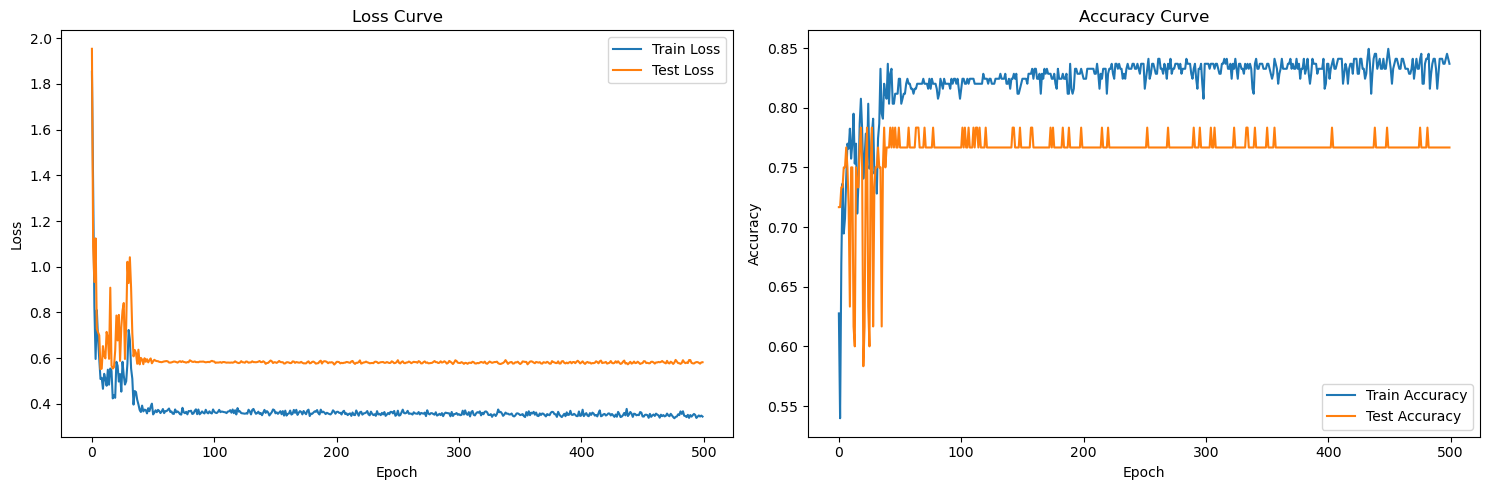

In [15]:
# Train the logistic regression model
results = train_logreg_simplified(
    batch_size=32,
    train_feats_data=train_feats,
    test_feats_data=test_feats,
    feature_dim=train_feats.tensors[0].shape[1],
    num_classes=2,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=500
)

#print(f"Final Train Accuracy: {results['train_acc']:.4f}, Final Test Accuracy: {results['test_acc']:.4f}")


In [16]:
print(f"Best Train Accuracy: {results['best_train_acc']:.4f} at Epoch {results['best_train_epoch']}")
print(f"Best Test Accuracy: {results['best_test_acc']:.4f} at Epoch {results['best_test_epoch']}")

Best Train Accuracy: 0.8494 at Epoch 434
Best Test Accuracy: 0.7833 at Epoch 19


In [13]:
train_feats.tensors[0].shape[1]

27648

In [13]:
results

{'train_acc': 0.8410041841004184, 'test_acc': 0.7666666666666667}